### 0. Загрузка данных

In [149]:
from pandas import read_csv
data = read_csv('WAG_C_M.csv', ';', index_col='month', parse_dates=['month'], dayfirst=True)
data.head()

,WAG_C_M
month,
1993-01-01,15.3
1993-02-01,19.1
1993-03-01,23.6
1993-04-01,30.6
1993-05-01,37.5


### 1. Визуальный анализ данных

Populating the interactive namespace from numpy and matplotlib


<Figure size 432x576 with 0 Axes>

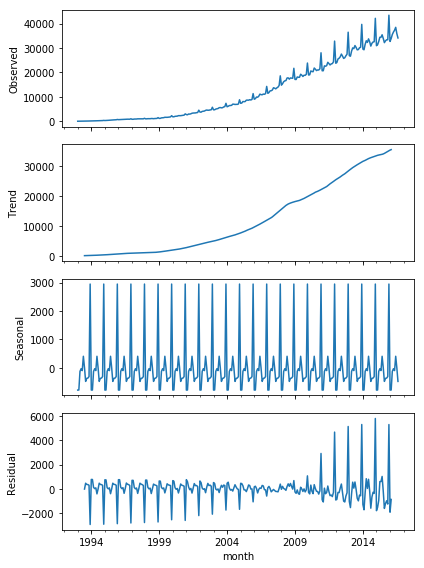

In [151]:
import matplotlib.pyplot as plt
%pylab inline
import statsmodels.api as sm
plt.figure(figsize(6, 8))
sm.tsa.seasonal_decompose(data.WAG_C_M).plot()
plt.show()

Из графиков видно, что дисперсия целевого параметра растет со временем. Для стабилизации дисперсии используем преобразование Бокса-Кокса

### 2. Стабилизация дисперсии

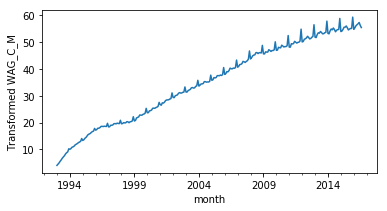

Критерий Дики-Фуллера после преобразования Бокса-Кокса c параметром 0.2632: 0.6968987634832688


In [152]:
from scipy.stats import boxcox
data['WAG_C_M_box'] , lam = boxcox(data.WAG_C_M)
plt.figure(figsize(6,3))
data.WAG_C_M_box.plot()
plt.ylabel('Transformed WAG_C_M')
plt.show()
print("Критерий Дики-Фуллера после преобразования Бокса-Кокса c параметром {}:"\
      " {}".format(round(lam, 4), sm.tsa.stattools.adfuller(data.WAG_C_M_box)[1]) )

Гипотеза о нестационарности не отвергается. Выполним сезонное дифференцирование.

### 3. Дифференцирование ряда

In [153]:
data['WAG_C_M_box_sdiff'] = data['WAG_C_M_box'] - data['WAG_C_M_box'].shift(12)
print("Критерий Дики-Фуллера после преобразования Бокса-Кокса c параметром {} и сезонного дифференцирования:" \
      " {}".format(round(lam, 4), sm.tsa.stattools.adfuller(data.WAG_C_M_box_sdiff.dropna())[1]) )

Критерий Дики-Фуллера после преобразования Бокса-Кокса c параметром 0.2632 и сезонного дифференцирования: 0.014697133494791808


После сезонного дифференцирования согласно критерию Дики-Фуллера гипотеза о нестационарности отвергается на уровне значимости 0.05. Оценим полученный ряд визуально.

<Figure size 432x576 with 0 Axes>

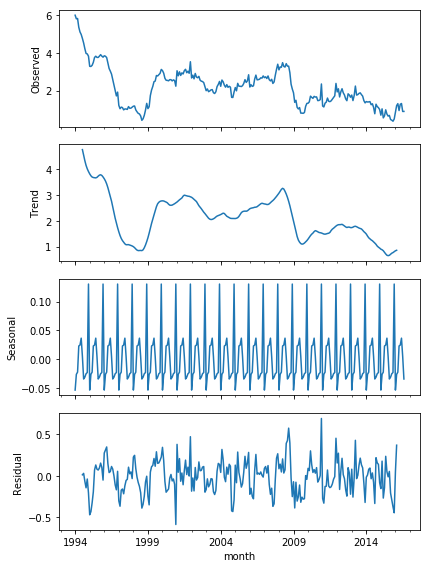

In [154]:
plt.figure(figsize(6,8))
sm.tsa.seasonal_decompose(data.WAG_C_M_box_sdiff[12:]).plot()
plt.show()

Можно видеть, что как и в случае, рассмотренном в лекции, при использовании сезонного дифференцирования не удалось полностью избавиться от тренда. Несмотря на формальное опровержение гипотезы о нестационарности, проведем еще одно дифференцирование, рассчитаем параметр, оценим ряд визуально.

Критерий Дики-Фуллера после преобразования Бокса-Кокса c параметром 0.2632, сезонного и дополнительного 
дифференцирования: 5.203603715821878e-08


<Figure size 432x576 with 0 Axes>

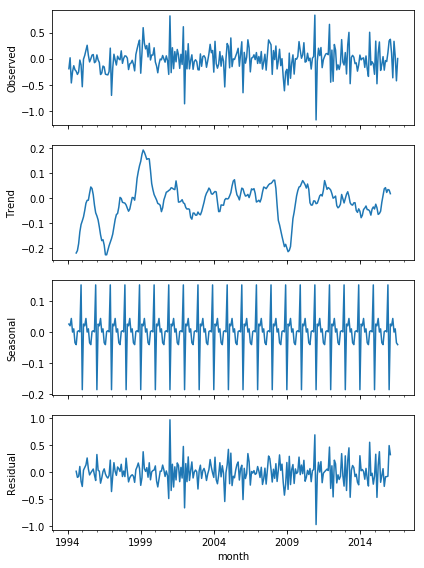

In [155]:
data['WAG_C_M_box_sdiff_1'] = data['WAG_C_M_box_sdiff'] - data['WAG_C_M_box_sdiff'].shift(1)
print("Критерий Дики-Фуллера после преобразования Бокса-Кокса c параметром {}, сезонного и дополнительного \n"\
      "дифференцирования: {}".format(round(lam, 4), sm.tsa.stattools.adfuller(data.WAG_C_M_box_sdiff_1.dropna())[1]) )
plt.figure(figsize(6,8))
sm.tsa.seasonal_decompose(data.WAG_C_M_box_sdiff_1.dropna()).plot()
plt.show()

Критерий Дики-Фуллера гипотезу о нестационарности уверенно отвергает. Выраженный тренд не наблюдается.

### 4. Выбор начальных приближений для p, q, P, Q

Для выбора начальных приближений параметров q, Q и p, P воспользуемся автокорреляционной (ACF) и частичной (PACF) автокорреляционной функцией ряда соответственно. Построение выполним для 60 лагов (5 лет).

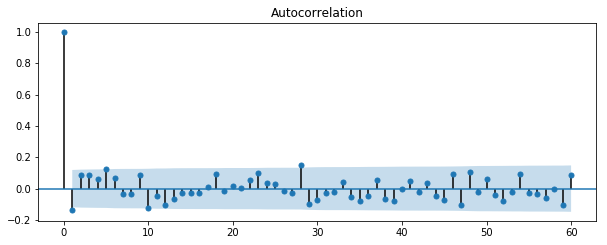

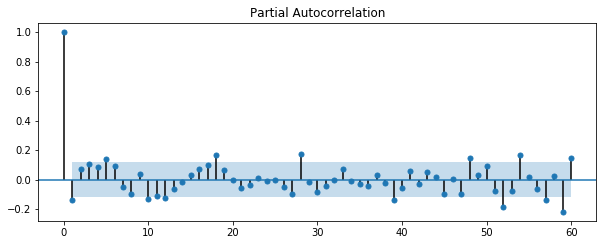

In [156]:
plt.figure(figsize(10,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data.WAG_C_M_box_sdiff_1.dropna().values.squeeze(), lags=60, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data.WAG_C_M_box_sdiff_1.dropna().values.squeeze(), lags=60, ax=ax)
pylab.show()

ACF: Значимые сезонные лаги отстутсвуют, Q = 0, значимый несезонный лаг на 28 может быть случайным из-за множественной проверки гипотез, выберем в качестве последнего значимого несезонного лага q = 10.

PACF: Значимые сезонные лаги: 12, 48 и 60. Два последних с высокой вероятностью случайны, поскольку отстутсвуют значимые сезонные лаги на 24 и 36. Зафиксируем P = 1. Выберем p = 10, поскольку это последний несезонный значимый лаг в рамках период сезона.

In [157]:
import warnings
from itertools import product
ps = range(0, 10+1)
d=1
qs = range(0, 10+1)
Ps = range(0, 1+1)
D=1
Qs = range(0, 0+1)
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

242

Моделей получилось ощутимо больше, чем в примере из лекции, но безумству храбрых поем мы песню. Воспользуемся кодом из лекции для расчета AIC критериев для различных моделей.

### 5. Обучение и сравнение моделей-кандидатов, выбор победителя

In [158]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(data.WAG_C_M_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

wrong parameters: (1, 2, 0, 0)
wrong parameters: (1, 2, 1, 0)
wrong parameters: (2, 1, 0, 0)
wrong parameters: (2, 1, 1, 0)
wrong parameters: (2, 2, 0, 0)
wrong parameters: (2, 2, 1, 0)
wrong parameters: (3, 2, 0, 0)
wrong parameters: (3, 2, 1, 0)
wrong parameters: (3, 10, 0, 0)
wrong parameters: (3, 10, 1, 0)
wrong parameters: (4, 2, 0, 0)
wrong parameters: (4, 2, 1, 0)
wrong parameters: (4, 4, 0, 0)
wrong parameters: (4, 4, 1, 0)
wrong parameters: (4, 10, 0, 0)
wrong parameters: (4, 10, 1, 0)
wrong parameters: (5, 2, 0, 0)
wrong parameters: (5, 2, 1, 0)
wrong parameters: (5, 3, 0, 0)
wrong parameters: (5, 3, 1, 0)
wrong parameters: (5, 4, 0, 0)
wrong parameters: (5, 4, 1, 0)
wrong parameters: (5, 9, 0, 0)
wrong parameters: (5, 9, 1, 0)
wrong parameters: (6, 3, 0, 0)
wrong parameters: (6, 3, 1, 0)
wrong parameters: (6, 4, 0, 0)
wrong parameters: (6, 4, 1, 0)
wrong parameters: (6, 7, 0, 0)
wrong parameters: (6, 7, 1, 0)
wrong parameters: (6, 8, 0, 0)
wrong parameters: (6, 8, 1, 0)
wron

In [159]:
from pandas import DataFrame
result_table = DataFrame(results)
result_table.columns = ['parameters', 'aic']
print("ТОР5 моделей: \n", result_table.sort_values(by = 'aic', ascending=True).head())

ТОР5 моделей: 
        parameters        aic
99   (5, 5, 1, 0) -25.099843
87   (4, 6, 1, 0) -25.094731
85   (4, 5, 1, 0) -23.891673
115  (6, 5, 1, 0) -22.707824
89   (4, 7, 1, 0) -22.145586


Видно, что в топ2 попали модели (99, 87) с одинаковым числом параметров 11. Далее идут модели с числом параметров 10 и 12 (модели 85 и 115 соответственно), но для них значение aic выше. От установленных границ вариации p(=10) и q(=10) лучшая по aic модель отошла, что говорит об эффективности использования параметра информативности (т.е. модели с большим числом параметров были подавлены).

In [160]:
print("И наш победитель: \n", best_model.summary())

И наш победитель: 
                                  Statespace Model Results                                 
Dep. Variable:                        WAG_C_M_box   No. Observations:                  284
Model:             SARIMAX(5, 1, 5)x(1, 1, 0, 12)   Log Likelihood                  24.550
Date:                            Sun, 10 Feb 2019   AIC                            -25.100
Time:                                    14:40:05   BIC                             18.126
Sample:                                01-01-1993   HQIC                            -7.744
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2210      1.093     -0.202      0.840      -2.362       1.921
ar.L2          

### 6. Остатки построенной модели

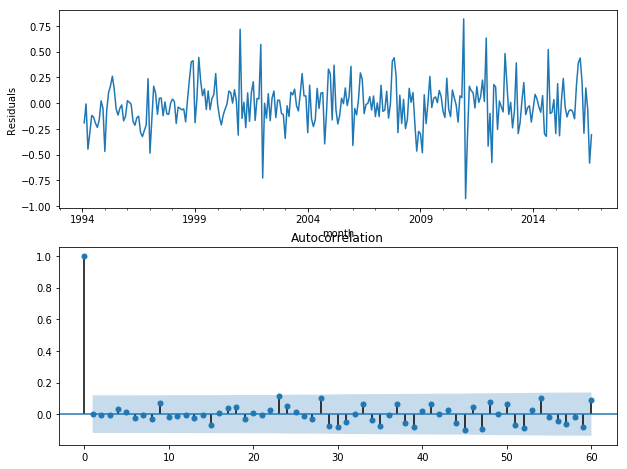

Критерий Стьюдента: p=0.170520
Критерий Дики-Фуллера: p=0.000000


In [161]:
from scipy.stats import ttest_1samp
plt.figure(figsize(10,8))
ax = plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')
ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=60, ax=ax)
plt.show()

print("Критерий Стьюдента: p=%f" % ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Остатки несмещены (подтверждается критерием Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой).

Вот как данные описываются построенной моделью:

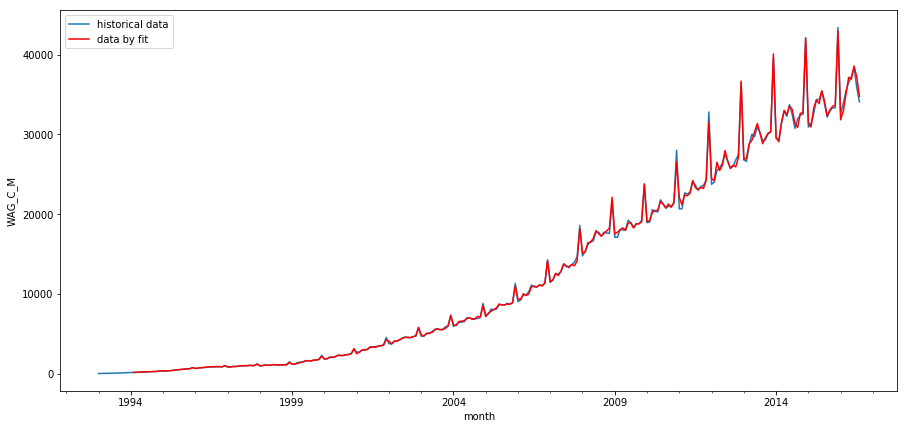

In [162]:
def invboxcox(y,lam):
   if lam == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lam*y+1)/lam))


data['model'] = invboxcox(best_model.fittedvalues, lam)
plt.figure(figsize(15,7))
data.WAG_C_M.plot(label='historical data')
data.model[13:].plot(color='r', label='data by fit')
plt.ylabel('WAG_C_M')
plt.legend()
pylab.show()

### 7. Прогнозирование с помощью финальной модели

Выполним прогнозирование на 3 года (36 месяца) вперед с месяца, следующего за последней записью (2016-08-01) в имеющихся данных. На этот же график можно наложить реальные данные до декабря 2018 года (файл WAG_C_M_update.csv).

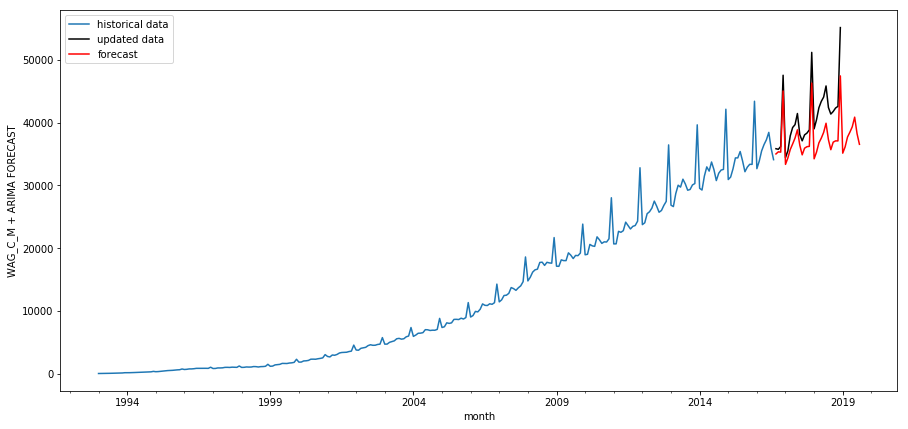

In [163]:
from pandas import concat
data_update = read_csv('WAG_C_M_update.csv', ";", index_col='month', parse_dates=['month'], dayfirst=True)
data2 = data[['WAG_C_M']]
date_list = [datetime.datetime.strptime("2016-09-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,36)]
future = DataFrame(index=date_list, columns= data2.columns)
data2 = concat([data2, future])
data2['forecast'] = invboxcox(best_model.predict(start=284, end=319), lam)

plt.figure(figsize(15,7))
data2.WAG_C_M.plot(label='historical data')
data_update.WAG_C_M.plot(color='k',label='updated data')
data2.forecast.plot(color='r',label='forecast')
plt.ylabel('WAG_C_M + ARIMA FORECAST')
plt.legend()
pylab.show()

По всему судя, ARIMA недооценила потенциал, и зарплаты стали даже больше, чем можно было ожидать в августе 2016 года. Расхождение прогноза с реальными данными растет со временем.